In [273]:
import pandas as pd
df = pd.read_csv('predictive_maintenance.csv')

由于这是时间序列数据，首先想到构建RNN模型进行预测
首先由于FP点很少，针对每个设备绘制折线图，查看每个设备失败的原因

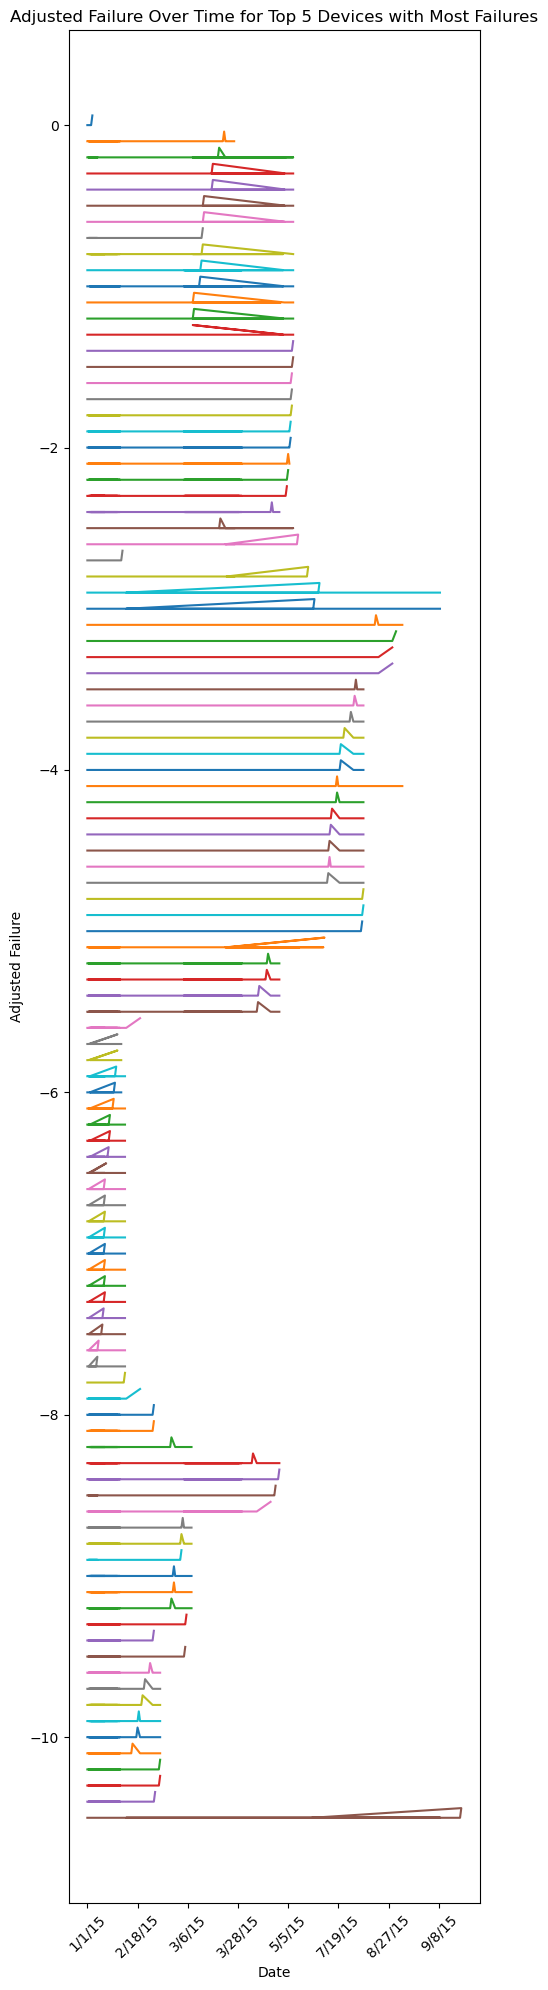

In [274]:
import pandas as pd
import matplotlib.pyplot as plt


df_failure = df[df['failure'] == 1]
devices = df_failure['device'].value_counts().index.tolist()


df_top = df[df['device'].isin(devices)]
df_top = df_top.replace(1,0.06)
plt.figure(figsize=(5, 20))
offset = 0.0  # 初始偏移量
for device in devices:
    df_device = df_top[df_top['device'] == device].sort_values('date')
    plt.plot(df_device['date'], df_device['failure'] - offset, linestyle='-')
    offset += 0.1

# 设置X轴的日期标签数量和格式
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # 只显示10个日期标签
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Adjusted Failure')
plt.title('Adjusted Failure Over Time for Top 5 Devices with Most Failures')
plt.tight_layout()
plt.show()

In [275]:
# 检查是否有设备failure了两次
failed_devices = df[df['failure'] == 1]['device'].value_counts()
failed_devices = failed_devices[failed_devices > 1].index.tolist()
failed_devices

[]

In [276]:
# 筛选从来没有失败的设备和有失败的设备的信息
device_counts = df['device'].value_counts()

# Devices with failures
devices_with_failures = df[df['failure'] == 1]['device'].unique()
devices_with_failures_count = df[df['device'].isin(devices_with_failures)]['device'].value_counts()
avg_devices_with_failures = devices_with_failures_count.mean()

# Devices without failures
devices_without_failures = device_counts.index.difference(devices_with_failures)
devices_without_failures_count = df[df['device'].isin(devices_without_failures)]['device'].value_counts()
avg_devices_without_failures = devices_without_failures_count.mean()

result_without_failures = pd.DataFrame({
    'Device': devices_without_failures_count.index.tolist() + ['Average'],
    'Count': devices_without_failures_count.values.tolist() + [avg_devices_without_failures]
})

# Append average for devices with failures
result_with_failures = pd.DataFrame({
    'Device': devices_with_failures_count.index.tolist() + ['Average'],
    'Count': devices_with_failures_count.values.tolist() + [avg_devices_with_failures]
})
display(result_with_failures)
result_without_failures

,Device,Count
0,W1F0T0B1,299.000000
1,Z1F14BGY,282.000000
2,S1F0JGJV,278.000000
3,Z1F0MRPJ,230.000000
4,W1F11ZG9,229.000000
...,...,...
102,S1F11MB0,7.000000
103,S1F10E6M,7.000000
104,S1F0CTDN,7.000000
105,S1F0RRB1,5.000000


,Device,Count
0,Z1F0QLC1,304.000000
1,Z1F0KJDS,304.000000
2,Z1F0MA1S,304.000000
3,S1F0E9EP,304.000000
4,S1F0EGMT,304.000000
...,...,...
1059,Z1F0LKBP,5.000000
1060,S1F04KSC,4.000000
1061,W1F0WJFT,3.000000
1062,W1F1DA5ÿ,1.000000


分别查看有损坏情况的设备和没损坏情况的设备的数据量情况，发现平均数集中在100左右。
#### RNN模型架构(LSTM, GRU)
* 模型构想
首先我设想构建N个cell，每一个cell存储一种设备、在时间序列上的点的9个特征信息
由于失败的数量过少，所以在构造数据时默认认为这N个时间戳下设备都没有损坏。

* 输入数据
经过观察发现有损坏的设备的数据特征如下：大多数数据在损坏后就没什么数据了，所以我想只用损坏那天前的所有数据来训练。
因为是二分类问题，所以输入的数据分为两类：
**第一类**是在第N天设备损坏的情况，最后的输出为1；；**第二类**是在第N天设备没有损坏的情况，最后输出为0

* 输入不平衡的问题
由于存在损坏的设备：没有存在损坏的设备的比为1：10 (107:1064)
所以需要一个方法来平衡数据集，我的几个思路
1. 数据增强：对于每个损坏设备构造多个样本
对于第一类设备，可以取损坏当天和前后3天的数据都作为最终输出。且为了过采样，可以从前M天中抽取N天作为样本，这样对于每个设备就能构造出很
2. SMOTE
对于从来没有损坏的设备，如果强行构造损坏的数据点感觉不符合事实
对于有损坏的设备，在状态正常的时间线上构造损坏的数据点感觉也不符合事实
3. 权重调整：给予少数类更高的权重，从而在损失函数中增加对这些样本的惩罚。
4. ...


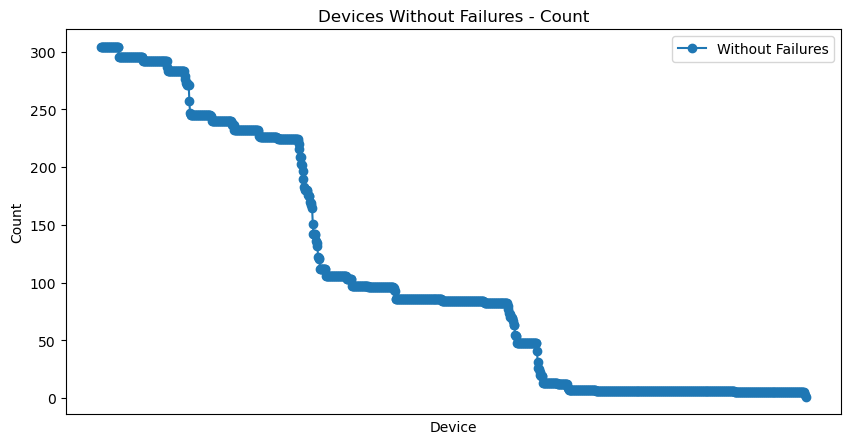

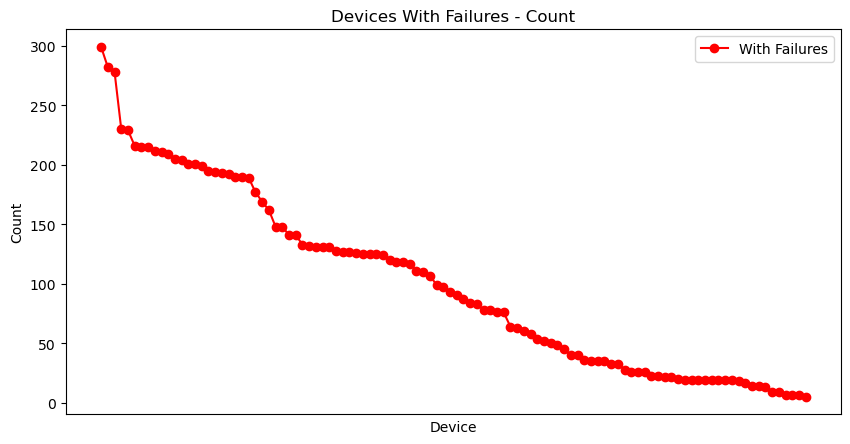

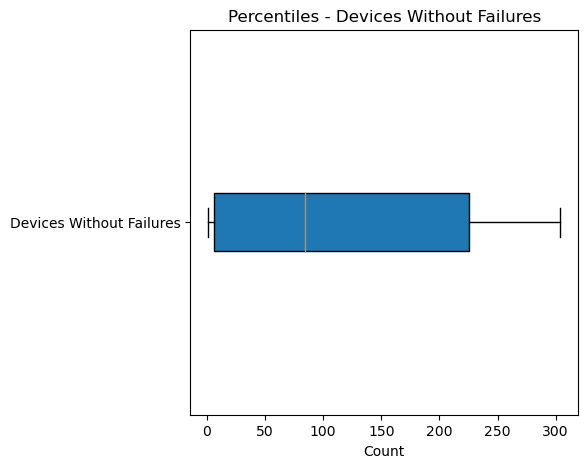

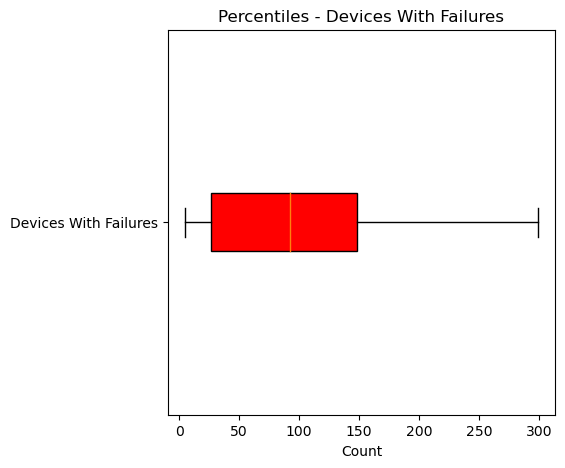

In [277]:
import numpy as np
plt.figure(figsize=(10, 5))
plt.plot(result_without_failures['Device'][:-1], result_without_failures['Count'][:-1], marker='o', label='Without Failures')
plt.title('Devices Without Failures - Count')
plt.xlabel('Device')
plt.xticks([])
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Devices with failures
plt.figure(figsize=(10, 5))
plt.plot(result_with_failures['Device'][:-1], result_with_failures['Count'][:-1], marker='o', color='red', label='With Failures')
plt.title('Devices With Failures - Count')
plt.xlabel('Device')
plt.xticks([])
plt.ylabel('Count')
plt.legend()
plt.show()

# Percentile plots
# Without failures
percentiles_without_failures = np.percentile(result_without_failures['Count'][:-1], [25, 50, 75])
plt.figure(figsize=(5, 5))
plt.boxplot(result_without_failures['Count'][:-1], vert=False, patch_artist=True)
plt.title('Percentiles - Devices Without Failures')
plt.yticks([1], ['Devices Without Failures'])
plt.xlabel('Count')
plt.show()

# With failures
percentiles_with_failures = np.percentile(result_with_failures['Count'][:-1], [25, 50, 75])
plt.figure(figsize=(5, 5))
plt.boxplot(result_with_failures['Count'][:-1], vert=False, patch_artist=True, boxprops=dict(facecolor='red'))
plt.title('Percentiles - Devices With Failures')
plt.yticks([1], ['Devices With Failures'])
plt.xlabel('Count')
plt.show()

构建一个采样函数，给定一个值n，从0到n随机取m个不同的数字，但是要求离n越近的数字概率越高。比如
n=20 m=5
[ 3 10 18 19 20]
[ 1 13 17 19 20]
权重函数利用$w(x)=e^{\text{scale}\times x}$
不过当x很大时，采样效果仍不理想，故引入强制选择参数

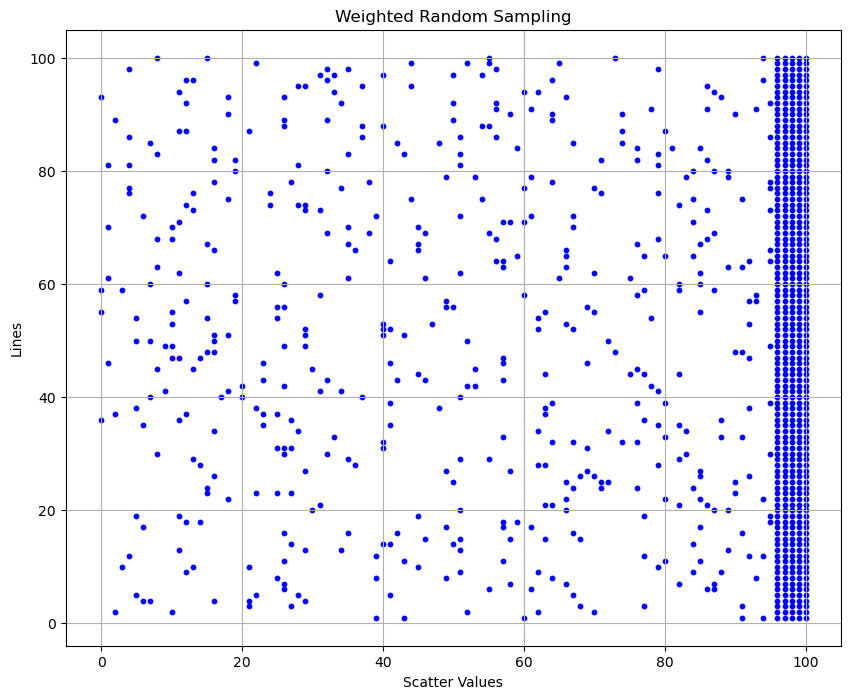

In [278]:
import random
import matplotlib.pyplot as plt
# def weighted_random_sampling(n, m, scale=0.2, forced=5):
#     numbers = np.arange(0, n+1)
#     weights = np.exp(scale * numbers-forced)
#     # print(len(weights))
#     remain = n-forced
#     selected_remain = m-forced-1
#     partition_sizes = np.ceil(weights[:selected_remain] / weights[:selected_remain].sum() * selected_remain).astype(int)
#     partition_len=len(partition_sizes)
#     # print(partition_sizes)
#     selected_indices = []
#     for idx,size in enumerate(partition_sizes):
#         indices = random.sample(range(int(np.ceil(idx * remain / partition_len)), int(np.ceil((idx + 1) * remain / partition_len))), k=size)
#         print(int(np.ceil(idx * remain / partition_len)), int(np.ceil((idx + 1) * remain / partition_len)))
#         selected_indices.append(indices)
#     selected_indices = np.concatenate(selected_indices)
#     forced_indices = list(range(n-forced+1, n+1))
#     selected = np.concatenate((forced_indices, selected_indices))
#     selected.sort()
#     # print(selected)
#     return selected[len(selected)-m:]

def weighted_random_sampling(n, m, scale=0.2, forced=5):
    remain = n-forced
    selected_remain = m-forced
    selected_indices = []
    indices = random.sample(range(remain+1), k=selected_remain)
    selected_indices.append(indices)
    selected_indices = np.concatenate(selected_indices)
    forced_indices = list(range(n-forced+1, n+1))
    selected = np.concatenate((forced_indices, selected_indices))
    selected.sort()
    return selected[len(selected)-m:]


num_lines = 100
n = 100
m = 10
scale = 0.1
plt.figure(figsize=(10, 8))
for _ in range(num_lines):
    selected = weighted_random_sampling(n, m, scale)
    selected.sort()
    # print(selected)
    plt.scatter(selected, [num_lines - _] * m, marker='o', color='blue',s=10)
plt.xlabel('Scatter Values')
plt.ylabel('Lines')
plt.title('Weighted Random Sampling')
plt.grid(True)
plt.show()

先从start_idx到end_idx之间选取一个最后的索引，再从0到最后的索引之间按照时间顺序选取10个样本点（必须包括最后一个索引），append到samples中。
其中进行的抽样逻辑如下：
如果一共样本数量小于10，那么在抽取所有样本后随机抽取，填充到10个（按照时间顺序），并且抽取$min(C^n_10,5)$，次
如果样本数量大于10，那么抽取$min(C^{10}_N /8 , 100)$次


In [279]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy.special import comb
import random
# LSTM模型一共有几个cell
cell_N=10
# 对一件设备于抽取时，有损坏的设备最大抽多少个
failed_max = 100
# 对一件设备于抽取时，没有损坏的设备最大抽多少个
normal_max = 10

df.sort_values(by=['device', 'date'], inplace=True)



def generate_samples(device_df, n_days=2, n_samples=10):
    samples = []
    labels = []
    device_df = device_df.reset_index(drop=True)

    # 这个标志判断这个设备是否有损坏
    flag = len(device_df[device_df['failure'] == 1]['date']) > 0

    if flag :#有损坏
        idx = device_df.index[device_df['failure'] == 1][0]
    else:
        idx = len(device_df)

    start_idx = max(idx - n_days, 0)
    end_idx = min(idx + n_days + 1, len(device_df))
    # 一共有N个样本待抽取
    N = end_idx + 1
    if end_idx + 1 < 10:
        num_samples_to_generate = 10 if flag else 5 # 不平衡数据集，如果没损坏就少抽点。。。
    else:
        num_combinations = comb(N, 10, exact=True) # C^10_N 个可能性
        ### 抽取规则
        num_samples_to_generate = min(num_combinations // 8, failed_max if flag else normal_max)
    # print(flag, num_samples_to_generate,N)
    for _ in range(num_samples_to_generate):
        final_idx = np.random.randint(start_idx, end_idx)
        if len(device_df)<10:
            selected_indices = np.arange(0, len(device_df))
            fill_indices = np.random.choice(selected_indices, 10 - len(device_df), replace=True)
            selected_indices = np.concatenate([selected_indices, fill_indices])
            selected_indices.sort()
            # print(selected_indices)
        else:
            # 索引加权，使得离 final_idx 越近的索引对应的权重越大。
            final_idx = 10 if final_idx<10 else final_idx
            selected_indices = weighted_random_sampling(final_idx, 10)
            # print(selected_indices,idx)
        # 获取到了一个batch
        samples.append(device_df.iloc[selected_indices][['metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7', 'metric8', 'metric9']].values.tolist())
        labels.append(1 if flag else 0)

    return samples, labels

# 生成样本和标签
samples = []
labels = []
for device, device_df in tqdm(df.groupby('device'),total=len(df.groupby('device'))) :
    device_samples, device_labels = generate_samples(device_df)
    samples.extend(device_samples)
    labels.extend(device_labels)

# 分割数据集
X_train, X_temp, y_train, y_temp = train_test_split(samples, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

100%|██████████| 1169/1169 [00:06<00:00, 175.66it/s]


In [280]:
y_train
indices_true = [index for index, value in enumerate(y_train) if value == 1]
indices_false = [index for index, value in enumerate(y_train) if value == 0]
len(indices_true)/len(indices_false)

1.096549765724833

In [281]:
X_train

[[[84128008, 0, 1, 6, 13, 221777, 0, 0, 1],
  [49313072, 0, 1, 6, 13, 226753, 0, 0, 1],
  [162806496, 0, 1, 6, 13, 226783, 0, 0, 1],
  [145380992, 0, 1, 6, 13, 267946, 0, 0, 1],
  [186541480, 0, 1, 6, 13, 314805, 0, 0, 1],
  [228791992, 0, 1, 6, 13, 303212, 0, 0, 1],
  [187337488, 0, 1, 6, 13, 303212, 0, 0, 1],
  [207663744, 0, 1, 6, 13, 303216, 0, 0, 1],
  [137590512, 0, 1, 6, 13, 303232, 0, 0, 1],
  [215034808, 0, 1, 6, 13, 303296, 0, 0, 1]],
 [[7834768, 0, 0, 0, 12, 224988, 0, 0, 0],
  [242021968, 0, 0, 0, 12, 224998, 0, 0, 0],
  [177641192, 0, 0, 0, 12, 227657, 0, 0, 0],
  [179405008, 0, 0, 0, 12, 256748, 0, 0, 0],
  [182835344, 0, 0, 0, 12, 256774, 0, 0, 0],
  [224932352, 0, 0, 0, 12, 256774, 0, 0, 0],
  [206373016, 0, 0, 0, 12, 256774, 0, 0, 0],
  [193511720, 0, 0, 0, 12, 256774, 0, 0, 0],
  [46419680, 0, 0, 0, 12, 251605, 0, 0, 0],
  [44849120, 0, 0, 0, 12, 251605, 0, 0, 0]],
 [[154090080, 0, 0, 0, 90, 241362, 0, 0, 0],
  [84804032, 0, 0, 0, 90, 241376, 0, 0, 0],
  [180782360, 0

In [282]:
y_train

[0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,


In [283]:
print(len(X_train),len(y_train))
print(len(X_val),len(y_val))
print(len(X_test),len(y_test))

14766 14766
1846 1846
1846 1846


通过pytorch构建tensor

In [284]:
import torch
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_train_tensor_shape = X_train_tensor.shape
y_train_tensor_shape = y_train_tensor.shape
X_train_tensor_shape, y_train_tensor_shape

(torch.Size([14766, 10, 9]), torch.Size([14766]))

In [288]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score, f1_score, roc_auc_score
def evaluate_model(y_true, y_pred, y_prob):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f'cal:{tn} {fp} {fn} {tp}')
    specificity = tn / (tn + fp)
    if y_prob.shape[1] == 1:  # 如果y_prob只有一列
        roc_auc = roc_auc_score(y_true, y_prob[:, 0])
    else:
        roc_auc = roc_auc_score(y_true, y_prob[:, 1])
    return precision, recall, specificity, f1, roc_auc


# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 参数
input_dim = 9  # 输入特征的维度
hidden_dim = 100  # LSTM的隐藏层维度
layer_dim = 1  # LSTM的层数
output_dim = 1  # 输出维度
learning_rate = 0.01
epochs = 10

# 检查是否有可用的CUDA设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# 模型实例化并移至GPU
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
model.to(device)

# 损失函数和优化器
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 数据加载器
batch_size = 256
train_dataset = TensorDataset(X_train_tensor.to(device), y_train_tensor.to(device))
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# 训练模型
model.train()
for epoch in range(epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# 测试模型
model.eval()
with torch.no_grad():
    # 注意：这里需要将测试集也转换为Tensor，并且移至GPU上
    X_test_tensor = torch.tensor(X_test, dtype=torch.float).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
    outputs = model(X_test_tensor)
    predicted = torch.round(torch.sigmoid(outputs.squeeze()))
    accuracy = (predicted == y_test_tensor).float().mean()
    print(f'Test Accuracy: {accuracy.item()}')
    y_prob = torch.sigmoid(outputs).cpu().numpy()  # 获取概率值
    y_pred = torch.round(torch.sigmoid(outputs.squeeze())).cpu().numpy()  # 预测的标签
    y_true = y_test_tensor.cpu().numpy()
    print(len(y_prob),len(y_pred),len(y_true))
precision, recall, specificity, f1, roc_auc = evaluate_model(y_true, y_pred, y_prob)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Specificity: {specificity}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

cuda
Epoch 1, Loss: 0.6921570897102356
Epoch 2, Loss: 0.6950696110725403
Epoch 3, Loss: 0.6940628886222839
Epoch 4, Loss: 0.6933396458625793
Epoch 5, Loss: 0.6927965879440308
Epoch 6, Loss: 0.6923441886901855
Epoch 7, Loss: 0.6919521689414978
Epoch 8, Loss: 0.6916055083274841
Epoch 9, Loss: 0.6912955641746521
Epoch 10, Loss: 0.6910164952278137
Test Accuracy: 0.5287107229232788
1846 1846 1846
cal:7 869 1 969
Precision: 0.5272034820457019
Recall: 0.9989690721649485
Specificity: 0.007990867579908675
F1 Score: 0.6901709401709402
ROC AUC: 0.5126012098102906
